# **1.0 INTRODUCTION**
The business task is to decide which of the zipcodes is best to invest in.


## **1.1 Import Dependencies**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## **1.2 Data Cleaning**

In [4]:
df = pd.read_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/zillow_data.csv')

In [5]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Firstly, we'll drop ***RegionID*** as it is the same as ***RegionName***.<br>
While we're at it, we'll rename our ***RegionName*** to ***zipcode***.

In [6]:
df = df.drop('RegionID', axis = 1)
df = df.rename({'RegionName': 'zipcode'}, axis = 1)

When we look at the dataframe, we can see we have over 200 columns which represent years. <br>
What we want is a single column that has each of the dates as rows.<br>
Let's alter our dataframe.

In [7]:
df = pd.melt(df, id_vars=['zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
df.head()

,zipcode,City,State,Metro,CountyName,SizeRank,time,value
0,60657,Chicago,IL,Chicago,Cook,1,1996-04,334200.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04,235700.0
2,77494,Katy,TX,Houston,Harris,3,1996-04,210400.0
3,60614,Chicago,IL,Chicago,Cook,4,1996-04,498100.0
4,79936,El Paso,TX,El Paso,El Paso,5,1996-04,77300.0


Now that we've got the structure right, we'll make our ***time*** column a datetime object.

In [8]:
df['time'] = pd.to_datetime(df['time'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901595 entries, 0 to 3901594
Data columns (total 8 columns):
 #   Column      Dtype         
---  ------      -----         
 0   zipcode     int64         
 1   City        object        
 2   State       object        
 3   Metro       object        
 4   CountyName  object        
 5   SizeRank    int64         
 6   time        datetime64[ns]
 7   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 238.1+ MB


In [10]:
df.isna().sum()

zipcode            0
City               0
State              0
Metro         276395
CountyName         0
SizeRank           0
time               0
value         156891
dtype: int64

We can see a large amount of na values for both the ***value*** and ***metro*** column. 
The metro column is not so important so it can be dropped. Regarding the na values in the value column, we can fill them using *backfilling*.

In [11]:
df = df.drop('Metro', axis = 1)

For the backfilling, we'll first of all sort our dataframe by zipcode and dates.

In [12]:
df = df.sort_values(by = ['zipcode', 'time'])
df = df.backfill()

## **1.3 EDA**
Recall that the task is to use ML to decide on which is the best zipcode to invest in. <br>
We'll begin our EDA by looking at exactly how many zipcodes we have to choose from.

In [13]:
len(set(df['zipcode']))

14723

We have over ***14.7k*** zipcodes to choose from. <br>
It would be a laborious task to go through each zipcode one by one and determine the best one to invest in. <br>
A better approach would be to narrow our search down. Let's say by ***state*** and view ROI over the past 5 years for each state.

In [16]:
# We'll take note of our most recent date. 2018-04
df['time'].max()

Timestamp('2018-04-01 00:00:00')

In [17]:
# We'll firstly create our dataframe that shows the median prices per period for each state
state_df =  df.groupby(['State', 'time']).median().drop(['zipcode', 'SizeRank'], axis = 1)
state_df

value
State time                
AK    1996-04-01  118800.0
      1996-05-01  119450.0
      1996-06-01  120150.0
      1996-07-01  120850.0
      1996-08-01  121300.0
...                    ...
WY    2017-12-01  215000.0
      2018-01-01  216800.0
      2018-02-01  219000.0
      2018-03-01  221000.0
      2018-04-01  221700.0

[13515 rows x 1 columns]

In [18]:
# We'll then reset the index because we want to easily specify the time period
state_df = state_df.reset_index()

In [19]:
# We'll specify 5 years prior to our most recent date i.e. 2013 - 04
state_df_2013 = state_df[state_df['time'] == '2013-04']
# We can rename our value column to 2013 price
state_df_2013.rename({'value': '2013_price'}, axis=1, inplace = True)
# We now no longer need the time column
state_df_2013.drop('time', axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
state_df_2013.head()

,State,2013_price
204,AK,278900.0
469,AL,121600.0
734,AR,111500.0
999,AZ,168000.0
1264,CA,361300.0


In [21]:
# We then perform the exact same steps for our most recetn date i.e. 2018-04
state_df_2018 = state_df[state_df['time'] == '2018-04']
state_df_2018.rename({'value': '2018_price'}, axis=1, inplace = True)
state_df_2018.drop('time', axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
state_df_2018.head()

,State,2018_price
264,AK,312100.0
529,AL,140500.0
794,AR,132500.0
1059,AZ,238450.0
1324,CA,564700.0


Now, all we need to do is combine both our dataframes into a single one.

In [23]:
state_df_2013_2018 = state_df_2013.merge(state_df_2018, left_on= 'State', right_on='State')
state_df_2013_2018.head()

,State,2013_price,2018_price
0,AK,278900.0,312100.0
1,AL,121600.0,140500.0
2,AR,111500.0,132500.0
3,AZ,168000.0,238450.0
4,CA,361300.0,564700.0


Whilst we have our prices, we want the ROI i.e. ***percentage change***.

In [24]:
state_df_2013_2018['5_year_change(%)'] = ((state_df_2013_2018['2018_price'] - state_df_2013_2018['2013_price']) / state_df_2013_2018['2013_price']) * 100

In [25]:
state_df_2013_2018.head()

,State,2013_price,2018_price,5_year_change(%)
0,AK,278900.0,312100.0,11.903908
1,AL,121600.0,140500.0,15.542763
2,AR,111500.0,132500.0,18.834081
3,AZ,168000.0,238450.0,41.934524
4,CA,361300.0,564700.0,56.296706


Finally, we just sort by State to give us the one with the highest ROI.

In [26]:
state_df_2013_2018.sort_values('5_year_change(%)', ascending=False)

,State,2013_price,2018_price,5_year_change(%)
33,NV,170000.0,287600.0,69.176471
9,FL,137700.0,226100.0,64.197531
5,CO,225700.0,365800.0,62.073549
7,DC,497250.0,785750.0,58.019105
37,OR,190750.0,298350.0,56.408912
4,CA,361300.0,564700.0,56.296706
47,WA,213600.0,333800.0,56.273408
44,UT,198000.0,291500.0,47.222222
13,ID,141900.0,206850.0,45.771670
22,MI,104600.0,150900.0,44.263862


In our case, we see that ***Nevada*** is the winner. <br><br>
What we'll now do is focus our attention on picking the best zipcode within Nevada. This significantly reduces time taken to do this project. <br><br>
But first, let's make sure to save this dataframe. We can make some visuals using ***tableau*** later on.

In [27]:
state_df_2013_2018.to_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/state_df_2013_2018.csv')

Firstly, we'll make a nevada dataframe that includes the median ***value*** and ***ROI***.

In [42]:
nv_df = pd.DataFrame(df[df['State'] == 'NV'].groupby('time').median()['value'])
nv_df['ROI'] = nv_df['value'].pct_change()
nv_df = nv_df.dropna()
nv_df.head()

,value,ROI
time,,
1996-05-01,144900.0,-0.001378
1996-06-01,144700.0,-0.001380
1996-07-01,144500.0,-0.001382
1996-08-01,144400.0,-0.000692
1996-09-01,144400.0,0.000000


We can then visualise the change in ROI with respect to change in value. 

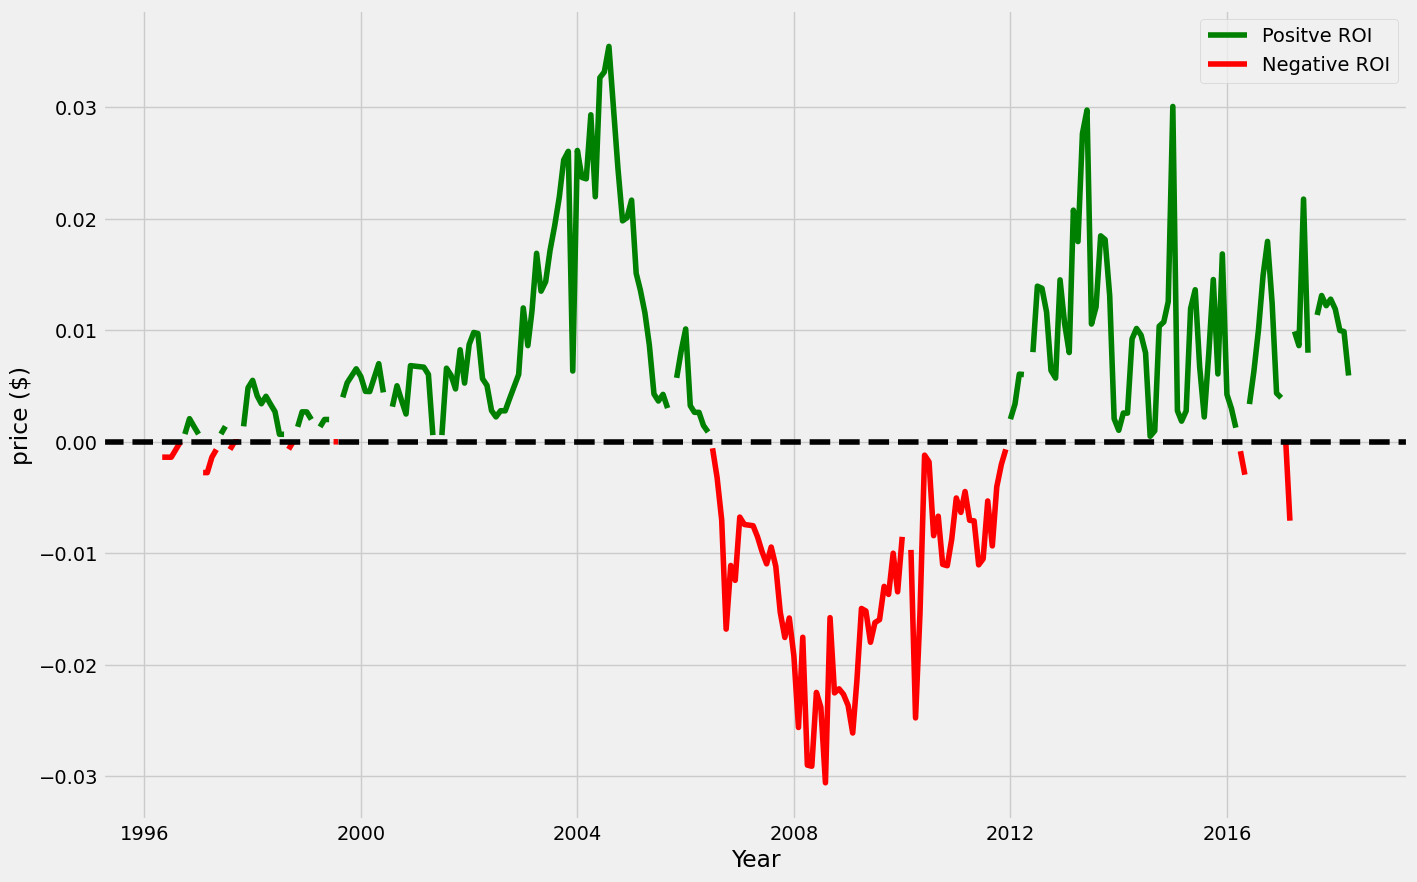

In [98]:
plt.style.use('fivethirtyeight')
ROI_plot = nv_df['ROI']
positive_ROI = ROI_plot.copy()
negative_ROI = ROI_plot.copy()

positive_ROI[positive_ROI <= 0 ] = np.nan
negative_ROI[negative_ROI > 0] = np.nan

fig, ax = plt.subplots(figsize = (15, 10))
plt.style.use('fivethirtyeight')
ax.plot(positive_ROI, color = 'green', label = 'Positve ROI')
ax.plot(negative_ROI, color = 'red', label = 'Negative ROI')
plt.axhline(y = 0, linestyle = '--' , color = 'black')
ax.set_ylabel('price ($)')
ax.set_xlabel('Year')
plt.legend();

We can visualise the median change in value of nevada property vs the entire country's since 1996 to now.

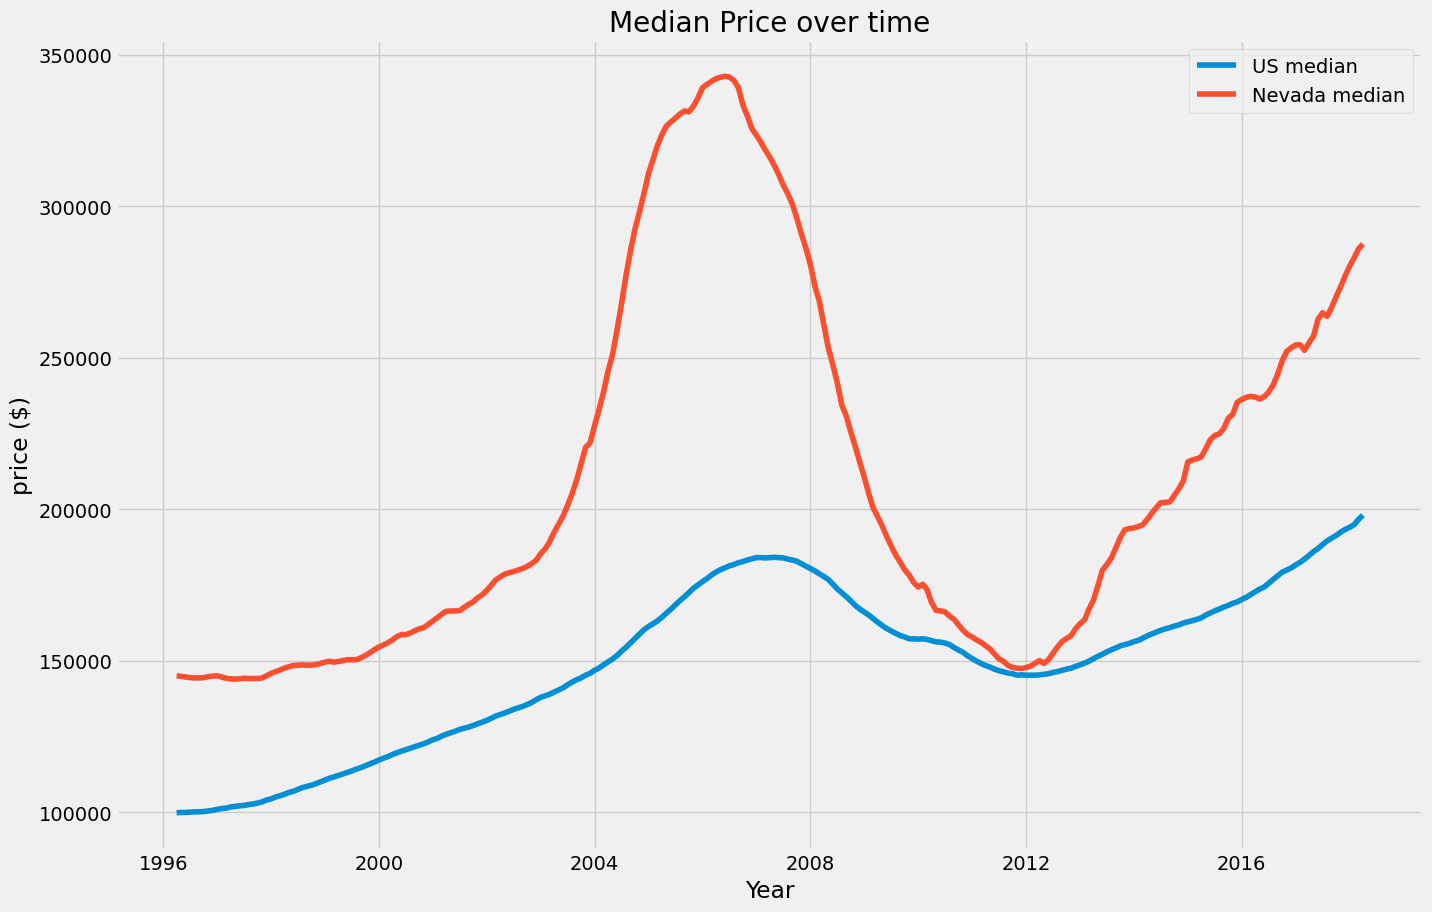

In [96]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.set_title('Median Price over time')
ax.set_ylabel('price ($)')
ax.set_xlabel('Year')
ax.plot(df.groupby('time').median()['value'], label = 'US median')
ax.plot(df[df['State'] == 'NV'].groupby('time').median()['value'], label = 'Nevada median')
plt.legend()
plt.show();

## **Preprocessing**

In [ ]:
df_nv = df[df['State'] == 'NV']

In [ ]:
df_nv.isna().sum()

RegionName       0
RegionID         0
SizeRank         0
City             0
State            0
Metro            0
CountyName       0
value         2469
dtype: int64

In [ ]:
df_nv.backfill(inplace = True)

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [ ]:
df_nv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27295 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionName  27295 non-null  int64  
 1   RegionID    27295 non-null  int64  
 2   SizeRank    27295 non-null  int64  
 3   City        27295 non-null  object 
 4   State       27295 non-null  object 
 5   Metro       27295 non-null  object 
 6   CountyName  27295 non-null  object 
 7   value       27295 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 1.9+ MB


In [ ]:
df_nv.drop(['RegionID', 'State'], axis = 1, inplace = True)

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
df_nv_2013 = df_nv.reset_index()[df_nv.reset_index()['time'] == '2013-04']

In [ ]:
df_nv_2013 = df_nv_2013.set_index('time')[['RegionName', 'value']].rename({'value': '2013_price'}, axis = 1)

In [ ]:
df_nv_2018 = df_nv.reset_index()[df_nv.reset_index()['time'] == '2018-04']

In [ ]:
df_nv_2018 = df_nv_2018.set_index('time')[['RegionName', 'value']].rename({'value': '2018_price'}, axis = 1)

In [ ]:
df_nv_2013_2018 = df_nv_2013.merge(df_nv_2018, left_on= 'RegionName', right_on='RegionName')

In [ ]:
df_nv_2013_2018['5_year_change(%)'] = ((df_nv_2013_2018['2018_price'] - df_nv_2013_2018['2013_price']) / df_nv_2013_2018['2013_price']) * 100


In [ ]:
df_nv_2013_2018.to_csv('more_data/df_nv_2013_2018.csv')

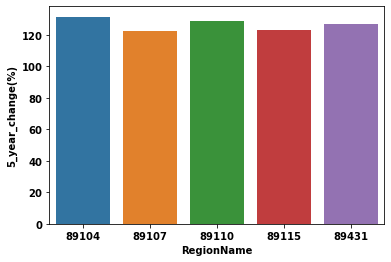

In [ ]:
sns.barplot(data = df_nv_2013_2018.sort_values(by = '5_year_change(%)', ascending = False)[['RegionName', '5_year_change(%)']][:5], x = 'RegionName', y = '5_year_change(%)');


In [ ]:
df_nv_5y_regions = df_nv['2013-04':][['RegionName', 'value']]
df_nv_5y_regions.head()

,RegionName,value
time,,
2013-04-01,89108,99800.0
2013-04-01,89121,100900.0
2013-04-01,89117,210200.0
2013-04-01,89052,283200.0
2013-04-01,89123,173000.0


In [ ]:
df_nv_5y_regions.to_csv('more_data/df_nv_5y_regions.csv')

<AxesSubplot:xlabel='time', ylabel='value'>

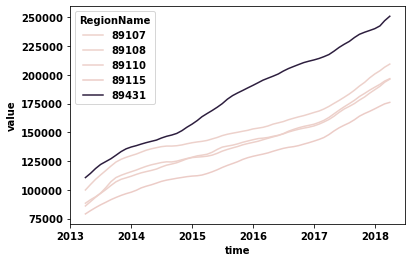

In [ ]:
sns.lineplot(data = 
                 df_nv_5y_regions[
                 (df_nv_5y_regions['RegionName'] == 89108) |
                 (df_nv_5y_regions['RegionName'] == 89107) |
                 (df_nv_5y_regions['RegionName'] == 89110) |
                 (df_nv_5y_regions['RegionName'] == 89115) |
                 (df_nv_5y_regions['RegionName'] == 89431)
                ].reset_index(), x = 'time', y = 'value', hue = 'RegionName'
            )

## **Feature Engineering** 

In [ ]:
from helper_functions import scrape_data

In [ ]:
scraped_data = [scrape_data(zipcode) for zipcode in list(set(df_nv['RegionName']))]

In [ ]:
missing_zipcodes = []
for i in scraped_data:
    if type(i) == dict:
        missing_zipcodes.append(i['RegionName'])

print(missing_zipcodes)
print(f'number of missing zipcodes: {len(missing_zipcodes)}')

['89155', '89411', '89440', '89448', '89449', '89021', '89034']
number of missing zipcodes: 7


In [ ]:
scraped_df_list = []
for i in scraped_data:
    if type(i) != dict:
        scraped_df_list.append(i)

In [ ]:
pd.Series([len(i) for i in scraped_df_list]).value_counts()

157    95
145     1
dtype: int64

In [ ]:
[len(i) for i in scraped_df_list].index(145)

66

In [ ]:
scraped_df_list.pop(66)

,time,population,household_income,population_density,RegionName
0,2006-01-01,509,49530,3.189423,89508
1,2006-02-01,1605,49656,10.057490,89508
2,2006-03-01,2743,49803,17.188283,89508
3,2006-04-01,3768,49952,23.615653,89508
4,2006-05-01,4750,50114,29.768092,89508
...,...,...,...,...,...
140,2017-09-01,11888,63971,74.491284,89508
141,2017-10-01,11892,64061,74.517457,89508
142,2017-11-01,11893,64124,74.527954,89508
143,2017-12-01,11893,64163,74.523474,89508


In [ ]:
len(scraped_df_list)

95

In [ ]:
scraped_df = pd.concat(scraped_df_list)
scraped_df['time'] = pd.to_datetime(scraped_df['time'] )
scraped_df.head()

,time,population,household_income,population_density,RegionName
0,2005-01-01,31083,57348,5799.067164,89102
1,2005-02-01,31115,57348,5805.093658,89102
2,2005-03-01,31179,57307,5816.983757,89102
3,2005-04-01,31268,57227,5833.711066,89102
4,2005-05-01,31390,57103,5856.390741,89102


In [ ]:
scraped_df.to_csv('more_data/scraped_df.csv')

In [ ]:
scraped_df = pd.read_csv('more_data/scraped_df.csv')
scraped_df['time'] = pd.to_datetime(scraped_df['time'])
scraped_df = scraped_df.set_index('time')

In [ ]:
CPI_df = pd.read_csv('more_data/CPIAUCSL.csv')
realGDP_df = pd.read_csv('more_data/GDPC1.csv')
inflation_rate_df = pd.read_csv('more_data/FPCPITOTLZGUSA.csv')
unemployment_df = pd.read_csv('more_data/UNRATE.csv')

In [ ]:
imported_df = reduce(lambda left,right: pd.merge(left,right,on='DATE'), 
                    [CPI_df, realGDP_df, inflation_rate_df, unemployment_df])

In [ ]:
imported_df = imported_df.rename(columns={'DATE': 'time',
                                         'CPIAUCSL': 'CPI', 
                                         'GDPC1': 'real_GDP', 
                                         'FPCPITOTLZGUSA': 'inflation', 
                                         'UNRATE': 'unemployment_rate'})

In [ ]:
imported_df['CPI'] = imported_df['CPI'].apply(lambda x: round(float(x), 2))
imported_df['real_GDP'] = imported_df['real_GDP'].apply(lambda x: round(x,2))
imported_df['inflation'] = imported_df['inflation'].apply(lambda x: round(x, 2))

In [ ]:
imported_df.to_csv('more_data/US_stats.csv')

In [ ]:
imported_df['time'] = pd.to_datetime(imported_df['time'])
imported_df = imported_df.set_index('time')
imported_df = imported_df.resample('M').mean()
imported_df = imported_df.interpolate(method = 'polynomial', order = 2)


In [ ]:
imported_df = imported_df.reset_index()
imported_df['time'] = imported_df['time'].apply(lambda x: str(x)[:-11] + '01')
imported_df['time'] = pd.to_datetime(imported_df['time'])
imported_df = imported_df.set_index('time')

In [ ]:
scraped_df

,time,population,household_income,population_density,RegionName
0,2005-01-01,31083,57348,5799.067164,89102
1,2005-02-01,31115,57348,5805.093658,89102
2,2005-03-01,31179,57307,5816.983757,89102
3,2005-04-01,31268,57227,5833.711066,89102
4,2005-05-01,31390,57103,5856.390741,89102
...,...,...,...,...,...
152,2017-09-01,5087,43112,749.247577,89086
153,2017-10-01,5092,43524,749.957954,89086
154,2017-11-01,5097,43952,750.728077,89086
155,2017-12-01,5103,44424,751.609290,89086


In [ ]:
imported_df

,CPI,real_GDP,inflation,unemployment_rate
time,,,,
1960-01-01,29.590000,3262.060000,1.460000,5.200000
1960-02-01,29.612993,3263.031886,1.406176,5.410187
1960-03-01,29.637870,3265.146971,1.353003,5.615978
1960-04-01,29.662239,3268.252643,1.305837,5.796546
1960-05-01,29.687724,3272.555946,1.261534,5.963926
...,...,...,...,...
2019-09-01,257.908499,18740.902127,1.399432,3.752504
2019-10-01,258.157015,18664.333216,1.354237,3.696914
2019-11-01,258.388694,18581.759208,1.312099,3.637952


In [ ]:
exogenous_variables = imported_df.reset_index().merge(scraped_df, 
                                                      how='inner', 
                                                      left_on = 'time', 
                                                      right_on = 'time')
                                                      
exogenous_variables.head()
exogenous_variables.to_csv('more_data/exogenous_variables.csv')

In [ ]:
exogenous_variables

,time,CPI,real_GDP,inflation,unemployment_rate,population,household_income,population_density,RegionName
0,2005-01-01,195.27,14901.27,3.39,5.3,31083,57348,5799.067164,89102
1,2005-01-01,195.27,14901.27,3.39,5.3,37853,43935,5649.701493,89103
2,2005-01-01,195.27,14901.27,3.39,5.3,36505,36208,6426.936620,89104
3,2005-01-01,195.27,14901.27,3.39,5.3,32025,61450,5865.384615,89107
4,2005-01-01,195.27,14901.27,3.39,5.3,57746,38994,6423.359288,89108
...,...,...,...,...,...,...,...,...,...
14910,2018-01-01,251.10,18606.79,2.44,4.0,47190,77973,5255.011136,89074
14911,2018-01-01,251.10,18606.79,2.44,4.0,36100,49184,4832.663989,89081
14912,2018-01-01,251.10,18606.79,2.44,4.0,27190,66156,2487.648673,89084
14913,2018-01-01,251.10,18606.79,2.44,4.0,3920,74334,7538.461538,89085


In [ ]:
exogenous_variables['RegionName'] = exogenous_variables['RegionName'].apply(lambda x: int(x))

In [ ]:
complete_df = exogenous_variables.merge(df_nv.reset_index(), left_on = ['time', 'RegionName'], right_on = ['time', 'RegionName'])

In [ ]:
complete_df.head()

,time,CPI,real_GDP,inflation,unemployment_rate,population,household_income,population_density,RegionName,SizeRank,City,Metro,CountyName,value
0,2005-01-01,195.27,14901.27,3.39,5.3,31083,57348,5799.067164,89102,2135,Las Vegas,Las Vegas,Clark,216000.0
1,2005-01-01,195.27,14901.27,3.39,5.3,37853,43935,5649.701493,89103,486,Las Vegas,Las Vegas,Clark,252000.0
2,2005-01-01,195.27,14901.27,3.39,5.3,36505,36208,6426.936620,89104,1961,Las Vegas,Las Vegas,Clark,198900.0
3,2005-01-01,195.27,14901.27,3.39,5.3,32025,61450,5865.384615,89107,2935,Las Vegas,Las Vegas,Clark,196800.0
4,2005-01-01,195.27,14901.27,3.39,5.3,57746,38994,6423.359288,89108,116,Las Vegas,Las Vegas,Clark,218500.0


In [ ]:
complete_df.to_csv('more_data/complete_df.csv')

In [ ]:
complete_df = pd.read_csv('more_data/complete_df.csv').drop('Unnamed: 0', axis = 1)

## **Modelling**

In [ ]:
def SARIMAX_model(zipcode, input_df):
    
    df = input_df[input_df['RegionName'] == zipcode]

    df = df.drop(['RegionName'], axis = 1)
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    df.dropna(inplace = True)
    df = pd.get_dummies(df)

    cutoff = round(df.shape[0]*0.8)

    train = df[:cutoff]
    test = df[cutoff:]

    X_train = train.drop('value', axis = 1)
    y_train = train['value']
    X_test = test.drop('value', axis = 1)
    y_test = test['value']

    train_auto_arima = auto_arima(y_train, 
                                  exog = X_train, 
                                  trace=True)
    
    summary_dict = train_auto_arima.get_params(deep = True)
    
    order = list(summary_dict['order'])
    order_1 = order[0]
    order_2 = order[1]
    order_3 = order[2]

    seasonal_order = list(summary_dict['seasonal_order'])
    seasonal_order_1 = seasonal_order[0]
    seasonal_order_2 = seasonal_order[1]
    seasonal_order_3 = seasonal_order[2]
    seasonal_order_4 = seasonal_order[3]

    model = ARIMA(
                  order = (order_1, order_2, order_3),
                  seasonal_order = (seasonal_order_1, seasonal_order_2, seasonal_order_3, seasonal_order_4),
                  suppress_warning = True,
                  with_intercept = False
                 )
    
    cv = RollingForecastCV(step = 2, h = 4)
    validation_smape = (np.mean(cross_val_score(estimator = model, 
                                                            y = y_train,
                                                            X = X_train, 
                                                            scoring = 'smape', 
                                                            cv = cv)))/100

    model.fit(y_train, X = X_train)
    
    test_forecasts = model.predict(n_periods = len(test), X = X_test)
    test_mape = np.abs(np.mean((np.array(y_test) - np.array(test_forecasts)) / np.array(y_test)))

    future_df = df
    y = future_df['value'] 
    X = future_df.drop('value', axis = 1)

    future_model = ARIMA(
                        order = (order_1, order_2, order_3),
                        seasonal_order = (seasonal_order_1, seasonal_order_2, seasonal_order_3, seasonal_order_4),
                        suppress_warning = True,
                        with_intercept = False
                        )

    future_model.fit(y)

    test_predicts = future_model.predict(n_periods = 4)
    may_2018_predict = list(test_predicts)[-1]

    final_dict = {zipcode: (validation_smape, test_mape, may_2018_predict, 'Sarimax')}

    return final_dict

In [ ]:
set(complete_df['RegionName']

In [ ]:
SARIMAX_models = [SARIMAX_model(zipcode, complete_df) for zipcode in set(complete_df['RegionName'])]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1960.470, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1962.137, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1962.136, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1964.085, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1962.369, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.700 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1935.842, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1903.434, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1905.432, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1905.432, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1905.367, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.313 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1919.258, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1909.885, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1912.708, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1911.860, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1911.880, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.526 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1903.135, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1904.847, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1904.846, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1904.951, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1905.135, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.357 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1883.337, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1887.581, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1885.239, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1887.326, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1885.209, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.345 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2460.618, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2454.681, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2458.099, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2461.886, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2456.662, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.276 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1862.050, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1870.316, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1871.466, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1871.456, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1873.283, Time=0.19 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1878.179, Time=0.28 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 2.015 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Damola\anaconda3\envs\learn-en

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1955.090, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1951.053, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1951.243, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1951.290, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1941.916, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1943.989, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1952.116, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1950.539, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1950.261, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1948.993, Time=0.19 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.965 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1898.924, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1880.399, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1881.853, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1881.850, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1882.390, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.296 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1970.284, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1961.972, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1961.577, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1961.624, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1961.485, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1957.472, Time=0.08 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=1969.911, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1954.318, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=1955.537, Time=0.24 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1973.539, Time=0.31 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=1972.746, Time=0.13 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1956.065, Time=0.35 sec

Best model:  ARIMA(3,2,1)(0,0,0)[0]          
Total fit time: 1.756 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1926.850, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1933.325, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1928.703, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1930.576, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1928.769, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.439 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1944.729, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1948.108, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1946.576, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1946.666, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.384 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2020.834, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2007.178, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2009.033, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2009.276, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2013.713, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2009.148, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.193 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1851.177, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1853.177, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1853.177, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1854.581, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1853.166, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.528 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1890.307, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1886.976, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1887.230, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1885.787, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1885.517, Time=0.07 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=1886.874, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1883.602, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1882.111, Time=0.25 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1881.079, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1882.136, Time=0.18 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1886.217, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1882.642, Time=0.22 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.728 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1916.454, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1915.623, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1915.686, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1926.388, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1909.657, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1911.496, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1916.076, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1912.048, Time=0.21 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.067 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2660.697, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2476.149, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2479.318, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2493.222, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2481.712, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2492.357, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.594 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1904.891, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1905.695, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1903.837, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1903.964, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1908.935, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1895.728, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1897.292, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1902.402, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1902.987, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1898.038, Time=0.20 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.888 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1888.947, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1928.908, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1927.900, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1928.028, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1909.583, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1909.872, Time=0.12 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1891.471, Time=0.25 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1890.930, Time=0.21 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1912.243, Time=0.13 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=1916.609, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1906.901, Time=0.16 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=1893.144, Time=0.33 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1894.919, Time=0.26 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 2.014 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1908.739, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1908.707, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1907.685, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1916.670, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1907.141, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1902.546, Time=0.08 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=1908.404, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1900.833, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1901.353, Time=0.19 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=1902.503, Time=0.26 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1887.418, Time=0.27 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=1890.018, Time=0.34 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=1889.093, Time=0.34 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1885.431, Time=0.24 sec
 ARIMA(1,2,3)(0,0,0)[0]          

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1980.294, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1976.112, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1976.483, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1976.503, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1972.778, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1984.817, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1976.101, Time=0.18 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1984.284, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1977.677, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1980.040, Time=0.18 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.170 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1963.594, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1954.148, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1952.850, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1952.940, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1966.882, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1946.173, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1961.892, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1946.837, Time=0.15 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1951.839, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1948.189, Time=0.17 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.811 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2021.795, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2010.045, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2021.718, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2012.025, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2032.766, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2011.819, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.269 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2049.578, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2038.535, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2041.714, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2039.841, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2035.760, Time=0.18 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2040.193, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2046.629, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2044.104, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2044.917, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2047.834, Time=0.04 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.556 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1939.806, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1940.910, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1940.929, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1933.654, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1935.634, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1935.630, Time=0.20 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1941.548, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1941.444, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1934.566, Time=0.20 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.162 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1923.855, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1949.101, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1950.596, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1950.609, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1936.775, Time=0.18 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1937.059, Time=0.16 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1923.881, Time=0.31 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1922.283, Time=0.28 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=1935.134, Time=0.21 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=1924.683, Time=0.33 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=1925.258, Time=0.34 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=1943.582, Time=0.10 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=1950.302, Time=0.38 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=1923.816, Time=0.34 sec

Best model:  ARIMA(2,2,3)(0,0,0)

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1936.737, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1917.861, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1919.756, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1919.755, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1933.715, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1919.650, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.469 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1977.713, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1964.672, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1966.535, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1966.536, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1961.289, Time=0.21 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1968.339, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1978.807, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1962.284, Time=0.19 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.225 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1976.863, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1987.044, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1988.844, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1987.796, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1997.761, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2006.943, Time=0.04 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1985.412, Time=0.27 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1981.603, Time=0.30 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1983.239, Time=0.15 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=1983.867, Time=0.19 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1987.025, Time=0.22 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=1982.007, Time=0.32 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 2.152 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarnin

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1900.416, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1894.759, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1900.672, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1895.426, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1890.810, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1892.781, Time=0.22 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1892.781, Time=0.20 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1897.034, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1896.958, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1891.624, Time=0.20 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.082 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2004.154, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1989.216, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1991.802, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1996.536, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1989.871, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1991.162, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.283 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1884.783, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1889.431, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1889.042, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1889.107, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1883.454, Time=0.18 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1889.262, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1881.686, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1883.349, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1889.027, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1888.372, Time=0.21 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.130 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1921.133, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1933.659, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1938.282, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1927.758, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1917.781, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1932.930, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1910.632, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1911.431, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1920.305, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1912.361, Time=0.19 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.798 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1967.135, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1967.964, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1967.241, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1959.942, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1962.370, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1965.160, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1974.685, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1971.673, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1965.278, Time=0.16 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.913 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1892.001, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1893.835, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1893.833, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1904.402, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1893.945, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.530 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1938.903, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1948.842, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1945.836, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1946.061, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1936.368, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1940.374, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1937.713, Time=0.11 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=1935.768, Time=0.18 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=1934.806, Time=0.09 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=1935.122, Time=0.11 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=1951.724, Time=0.14 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1936.796, Time=0.13 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 1.398 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Ma

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1906.738, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1963.087, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1949.140, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1950.188, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1925.287, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1925.586, Time=0.13 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1907.967, Time=0.22 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1907.122, Time=0.26 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1927.658, Time=0.17 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=1929.385, Time=0.17 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1924.131, Time=0.22 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=1911.502, Time=0.34 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1910.438, Time=0.29 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 2.270 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1954.993, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1955.924, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1957.198, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1962.922, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1947.394, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1966.213, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1945.894, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1947.397, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1965.050, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1946.925, Time=0.18 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.845 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1921.793, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1925.400, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1921.712, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1912.550, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1914.416, Time=0.19 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1914.412, Time=0.18 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1922.606, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1922.420, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1913.741, Time=0.21 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.082 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2007.322, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1992.561, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1994.910, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1996.331, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1998.502, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1994.445, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.105 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2125.809, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2105.457, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2107.544, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2109.133, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2111.394, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2107.352, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.123 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2250.501, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2214.011, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2218.745, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2234.004, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2215.967, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.217 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2559.301, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2386.939, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2377.344, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2404.348, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2390.581, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2367.689, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2359.636, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2353.772, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2349.867, Time=0.26 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2340.015, Time=0.31 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2343.744, Time=0.32 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2772.639, Time=0.40 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2440.895, Time=0.36 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2364.647, Time=0.25 sec

Best model:  ARIMA(5,1,1)(0,0,0)

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2039.438, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2018.298, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2020.347, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2021.403, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2022.295, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2020.151, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.384 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2667.840, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2669.370, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2669.436, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2665.938, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2670.570, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.381 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2652.061, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2653.956, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2654.012, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2650.148, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2653.968, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.420 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2261.471, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2252.931, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2255.106, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2255.501, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2257.391, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2254.897, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.236 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2538.306, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2538.633, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2538.678, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2543.632, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2539.527, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.402 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2147.456, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2113.747, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2117.020, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2121.756, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2123.819, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2115.528, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.110 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2614.854, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2594.909, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2595.395, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2602.689, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2604.155, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2596.834, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.346 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2163.250, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2130.507, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2133.395, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2137.767, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2139.956, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2132.417, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.108 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3105.692, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3097.459, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3099.454, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3099.513, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3096.899, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3101.510, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.279 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1918.423, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1901.588, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1903.588, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1903.588, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1905.504, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1903.489, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.373 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1903.285, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1905.017, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1905.017, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1895.972, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1897.392, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1897.366, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1907.017, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1907.017, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1897.508, Time=0.25 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.186 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1937.781, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1941.180, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1939.779, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1939.770, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.405 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1960.256, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1965.944, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1968.743, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1967.624, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1977.405, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1962.631, Time=0.17 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1968.588, Time=0.25 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1991.814, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=1982.827, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=1982.936, Time=0.32 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1971.704, Time=0.27 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 1.879 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2233.956, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2225.822, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2229.163, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2237.858, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2240.853, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2227.725, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.385 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2083.058, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2055.797, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2061.809, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2056.721, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2073.875, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2057.723, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.323 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2453.698, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2456.782, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2458.321, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2453.872, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2457.751, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.829 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2646.990, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2648.113, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2648.195, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2649.529, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2650.093, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.358 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2450.266, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2416.961, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2419.302, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2421.593, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2423.754, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2418.929, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.244 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2140.305, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2097.654, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2101.438, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2099.651, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2111.856, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2099.176, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.155 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2255.326, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2259.683, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2271.592, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2257.308, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.378 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1961.852, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1946.671, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1948.668, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1952.906, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1948.504, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.395 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1972.221, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1973.783, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1973.782, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1974.159, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.460 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1922.244, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1924.243, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1924.243, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1918.009, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1935.812, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1931.783, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1925.617, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1932.151, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1918.314, Time=0.19 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.029 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2051.374, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2024.043, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2026.834, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2025.972, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2046.153, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2025.954, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.176 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2372.368, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2294.348, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2297.332, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2303.708, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2305.883, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2296.316, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.192 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2183.543, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2144.582, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2147.027, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2152.695, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2158.952, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2146.546, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.149 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2459.243, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2450.986, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2455.716, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2460.884, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2452.970, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.454 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1967.211, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1966.777, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1967.869, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1978.555, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1964.488, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1970.705, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1985.800, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1968.357, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1975.214, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1967.987, Time=0.24 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.979 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2035.857, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2018.918, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2023.955, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2025.020, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2027.386, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2020.918, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.193 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2240.586, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2207.130, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2209.634, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2215.584, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2220.404, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2209.096, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.169 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2028.966, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2005.547, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2007.004, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2006.493, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2006.772, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2007.499, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.483 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1913.079, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1903.397, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1904.476, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1904.469, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1906.533, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1905.160, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.393 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1894.894, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1935.550, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1946.820, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1933.958, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1920.441, Time=0.19 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1920.569, Time=0.13 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1895.191, Time=0.27 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1921.419, Time=0.13 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=1919.160, Time=0.20 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1927.663, Time=0.12 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=1898.357, Time=0.32 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1902.399, Time=0.31 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 2.327 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1988.474, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1974.773, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1977.559, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1983.133, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1991.410, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1976.698, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.135 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1930.036, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1929.576, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1934.393, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1929.564, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1924.222, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1925.588, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1933.037, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1930.240, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1930.064, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1925.923, Time=0.18 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.042 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1890.194, Time=0.32 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1904.217, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1904.438, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1904.485, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1901.667, Time=0.29 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1901.994, Time=0.18 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1904.417, Time=0.25 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1904.834, Time=0.20 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1900.074, Time=0.11 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=1902.396, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1901.581, Time=0.19 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1907.182, Time=0.27 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 2.348 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2557.541, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2311.692, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2306.132, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2306.928, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2310.656, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2299.015, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2289.979, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2278.941, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2267.317, Time=0.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2262.203, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2291.800, Time=0.35 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2649.240, Time=0.41 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2486.781, Time=0.32 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2233.408, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0]          

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2322.702, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2322.383, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2320.351, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2325.239, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2248.303, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2326.924, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2319.032, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2318.741, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2270.190, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.499 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2518.480, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2518.793, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2518.880, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2520.908, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2519.170, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.389 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1864.269, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1866.496, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1864.697, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1864.831, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1857.243, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1864.695, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1855.689, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1857.965, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1864.246, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1857.258, Time=0.20 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.955 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1873.547, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1871.909, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1872.017, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1872.420, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1866.050, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1868.542, Time=0.19 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1868.544, Time=0.18 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1872.732, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1869.505, Time=0.24 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.304 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2598.540, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2348.543, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2345.178, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2345.626, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2347.476, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2341.342, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2336.476, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2329.807, Time=0.29 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2320.811, Time=0.26 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2323.437, Time=0.43 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2341.449, Time=0.38 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2322.415, Time=0.19 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0] intercept
Total fit time: 2.271 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
SARIMAX_avg_mape = np.mean([list(i.values())[0][1] for i in SARIMAX_models])
SARIMAX_avg_mape

for i in SARIMAX_models:
    for zipcode, values in i.items():
        SARIMAX_summary.update({zipcode: (values)})

SARIMAX_summary = {}
SARIMAX_summary

In [ ]:
def SARIMA_model(zipcode, input_df):
    
    df = input_df[input_df['RegionName'] == zipcode]

    df = df.drop(['RegionName'], axis = 1)
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    df.dropna(inplace = True)
    df = pd.get_dummies(df)

    cutoff = round(df.shape[0]*0.8)

    train = df[:cutoff]['value']
    test = df[cutoff:]['value']

    train_auto_arima = auto_arima(train,
                                  trace=True)
    
    summary_dict = train_auto_arima.get_params(deep = True)
    
    order = list(summary_dict['order'])
    order_1 = order[0]
    order_2 = order[1]
    order_3 = order[2]

    seasonal_order = list(summary_dict['seasonal_order'])
    seasonal_order_1 = seasonal_order[0]
    seasonal_order_2 = seasonal_order[1]
    seasonal_order_3 = seasonal_order[2]
    seasonal_order_4 = seasonal_order[3]

    model = ARIMA(
                  order = (order_1, order_2, order_3),
                  seasonal_order = (seasonal_order_1, seasonal_order_2, seasonal_order_3, seasonal_order_4),
                  suppress_warning = True,
                  with_intercept = False
                 )
    
    cv = RollingForecastCV(step = 2, h = 4)
    validation_smape = (np.mean(cross_val_score(estimator = model, 
                                                            y = train,
                                                            scoring = 'smape', 
                                                            cv = cv)))/100

    model.fit(train)
    
    test_forecasts = model.predict(n_periods = len(test))
    test_mape = np.abs(np.mean((np.array(test) - np.array(test_forecasts)) / np.array(test)))

    future_df = df
    y = future_df['value'] 

    future_model = ARIMA(
                        order = (order_1, order_2, order_3),
                        seasonal_order = (seasonal_order_1, seasonal_order_2, seasonal_order_3, seasonal_order_4),
                        suppress_warning = True,
                        with_intercept = False
                        )

    future_model.fit(y)

    may_2018_predict = list(future_model.predict(n_periods = 4))[-1:][0]

    final_dict = {zipcode: (validation_smape, test_mape, may_2018_predict, 'Sarima')}

    return final_dict

In [ ]:
SARIMA_model(89102, complete_df)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1960.470, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1962.137, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1962.136, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1964.085, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1962.369, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.651 seconds


{89102: (0.020042116656847506, 0.07399886897460586, 216900.0, 'Sarima')}

In [ ]:
def SARIMA_model(zipcode, input_df):
    
    df = input_df[input_df['RegionName'] == zipcode]

    df = df.drop(['RegionName'], axis = 1)
    df = df.set_index('time')
    df.dropna(inplace = True)
    df = pd.get_dummies(df)

    cutoff = round(df.shape[0]*0.8)

    train = df['value'][:cutoff]
    test = df['value'][cutoff:]

    train.dropna(inplace = True)
    test.dropna(inplace = True)

    train_auto_arima = auto_arima(train, 
                                  trace=True)
    
    train_auto_arima_summary = train_auto_arima.summary()    
    summary_dict = train_auto_arima.get_params(deep = True)
    
    order = list(summary_dict['order'])
    order_1 = order[0]
    order_2 = order[1]
    order_3 = order[2]

    seasonal_order = list(summary_dict['seasonal_order'])
    seasonal_order_1 = seasonal_order[0]
    seasonal_order_2 = seasonal_order[1]
    seasonal_order_3 = seasonal_order[2]
    seasonal_order_4 = seasonal_order[3]

    model = ARIMA(
                  order = (order_1, order_2, order_3),
                  seasonal_order = (seasonal_order_1, seasonal_order_2, seasonal_order_3, seasonal_order_4),
                  suppress_warning = True,
                  with_intercept = False
                 )

    model.fit(train)
    train_forecasts = model.predict_in_sample(train)
    validation_smape = np.abs(np.mean((np.array(train) - np.array(train_forecasts)) / np.array(train)))
    
    test_forecasts = model.predict(n_periods = len(test))
    test_mape = np.abs(np.mean((np.array(test) - np.array(test_forecasts)) / np.array(test)))

    future_df = df
    y = future_df['value'] 

    future_model = ARIMA(
                        order = (order_1, order_2, order_3),
                        seasonal_order = (seasonal_order_1, seasonal_order_2, seasonal_order_3, seasonal_order_4),
                        suppress_warning = True,
                        with_intercept = False
                        )

    future_model.fit(y)

    may_2018_predict = list(future_model.predict(n_periods = 4))[-1:][0]

    final_dict = {zipcode: (validation_smape, test_mape, may_2018_predict, 'Sarima')}
    return final_dict

In [ ]:
SARIMA_models = [SARIMA_model(zipcode, complete_df) for zipcode in set(complete_df['RegionName'])]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1960.470, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1962.137, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1962.136, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1964.085, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1962.369, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.648 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1935.842, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1903.434, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1905.432, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1905.432, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1905.367, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fi

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1955.090, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1951.053, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1951.243, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1951.290, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1941.916, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1943.989, Time=0.31 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1952.116, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1950.539, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1950.261, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1948.993, Time=0.23 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.252 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1898.924, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1880.399, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=188

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1926.850, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1933.325, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1928.703, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1930.576, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1928.769, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.500 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1944.729, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1948.108, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1946.576, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1946.666, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit tim

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1908.739, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1908.707, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1907.685, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1916.670, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1907.141, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1902.546, Time=0.10 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=1908.404, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1900.833, Time=0.22 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1901.353, Time=0.20 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=1902.503, Time=0.26 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1887.418, Time=0.30 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=1890.018, Time=0.36 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=1889.093, Time=0.37 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1885.431, Time=0.26 sec
 ARIMA(1,2,3)(0,0,0)[0]          

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1980.294, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1976.112, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1976.483, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1976.503, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1972.778, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1984.817, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1976.101, Time=0.19 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1984.284, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1977.677, Time=0.14 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1980.040, Time=0.20 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.268 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1963.594, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1954.148, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1952.850, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1952.940, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1966.882, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1946.173, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1961.892, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1946.837, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1951.839, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1948.189, Time=0.18 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.894 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2021.795, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2010.045, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=202

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1936.737, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1917.861, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1919.756, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1919.755, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1933.715, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1919.650, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.501 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1977.713, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1964.672, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1966.535, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1966.536, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1961.289, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Tim

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1900.416, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1894.759, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1900.672, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1895.426, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1890.810, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1892.781, Time=0.19 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1892.781, Time=0.19 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1897.034, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1896.958, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1891.624, Time=0.21 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.010 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2004.154, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1989.216, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=199

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1892.001, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1893.835, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1893.833, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1904.402, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1893.945, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.419 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1938.903, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1948.842, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1945.836, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1946.061, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1936.368, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1940.374, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1937.713

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting au

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1954.993, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1955.924, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1957.198, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1962.922, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1947.394, Time=0.31 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1966.213, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1945.894, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1947.397, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1965.050, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1946.925, Time=0.22 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.138 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1921.793, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1925.400

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2007.322, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1992.561, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1994.910, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1996.331, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1998.502, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1994.445, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.112 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2125.809, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2105.457, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2107.544, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2109.133, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2111.394, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2107.352, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]         

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2039.438, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2018.298, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2020.347, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2021.403, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2022.295, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2020.151, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.376 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2667.840, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2669.370, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2669.436, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2665.938, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2670.570, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Tot

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1937.781, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1941.180, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1939.779, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1939.770, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.403 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1960.256, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1965.944, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1968.743, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1967.624, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1977.405, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1962.631, Time=0.17 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1968.588, Tim

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2233.956, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2225.822, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2229.163, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2237.858, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2240.853, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2227.725, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.310 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2083.058, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2055.797, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2061.809, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2056.721, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2073.875, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2057.723, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]         

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2035.857, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2018.918, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2023.955, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2025.020, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2027.386, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2020.918, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.223 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2240.586, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2207.130, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2209.634, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2215.584, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2220.404, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2209.096, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]         

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertib

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1988.474, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1974.773, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1977.559, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1983.133, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1991.410, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1976.698, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.148 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1930.036, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1929.576, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1934.393, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1929.564, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1924.222, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1925.588, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=193

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1890.194, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1904.217, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1904.438, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1904.485, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1901.667, Time=0.24 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1901.994, Time=0.17 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1904.417, Time=0.22 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1904.834, Time=0.17 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1900.074, Time=0.11 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=1902.396, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1901.581, Time=0.18 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1907.182, Time=0.32 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 2.242 seconds


C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2557.541, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2311.692, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2306.132, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2306.928, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2310.656, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2299.015, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2289.979, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2278.941, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2267.317, Time=0.22 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2262.203, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2291.800, Time=0.31 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2649.240, Time=0.41 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2486.781, Time=0.34 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2233.408, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0]          

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2322.702, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2322.383, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2320.351, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2325.239, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2248.303, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2326.924, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2319.032, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2318.741, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2270.190, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.351 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2518.480, Time=0.0

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2593.143, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2596.798, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2605.124, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2595.122, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.387 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2019.448, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2035.911, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2037.967, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2008.152, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2019.469, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2005.372, Time=0.1

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2762.006, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2763.795, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2763.853, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2761.565, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2765.839, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.377 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3105.687, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3097.454, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3099.447, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3099.506, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3096.727, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3101.504, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Tot

In [ ]:
SARIMA_models[0]

({89102: (216900.0, 0.07399886897460586, 'SARIMA')},
 {'forecasts': array([150300., 151100., 151900., 152700., 153500., 154300., 155100.,
         155900., 156700., 157500., 158300., 159100., 159900., 160700.,
         161500., 162300., 163100., 163900., 164700., 165500., 166300.,
         167100., 167900., 168700., 169500., 170300., 171100., 171900.,
         172700., 173500., 174300.]),
  'test': time
  2015-07-01    150800.0
  2015-08-01    152200.0
  2015-09-01    153400.0
  2015-10-01    154800.0
  2015-11-01    156400.0
  2015-12-01    157900.0
  2016-01-01    159400.0
  2016-02-01    160600.0
  2016-03-01    161700.0
  2016-04-01    163100.0
  2016-05-01    164500.0
  2016-06-01    165800.0
  2016-07-01    168200.0
  2016-08-01    170900.0
  2016-09-01    173100.0
  2016-10-01    175200.0
  2016-11-01    177300.0
  2016-12-01    179200.0
  2017-01-01    180900.0
  2017-02-01    182000.0
  2017-03-01    183300.0
  2017-04-01    185600.0
  2017-05-01    188100.0
  2017-06-01    19

In [ ]:
SARIMA_dfs = [pd.DataFrame(i[1]) for i in SARIMA_models]

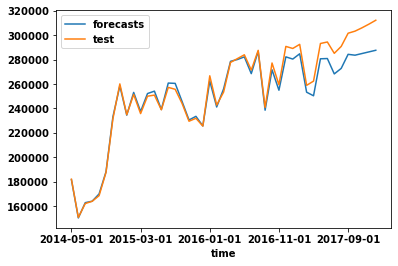

In [ ]:
ax = pd.concat(SARIMA_dfs).drop('zipcode', axis = 1).groupby('time').mean().plot()
fig =  ax.get_figure()
fig.savefig('SARIMA_performance.png')

In [ ]:
SARIMA_avg_mape = np.mean(value for i[0].items() in SARIMA_models])
SARIMA_avg_mape

AttributeError: 'tuple' object has no attribute 'values'

In [ ]:
SARIMA_summary = {}
for i in SARIMA_models:
    for zipcode, values in i.items():
        SARIMA_summary.update({zipcode: (values)})

In [ ]:
SARIMA_summary

{89102: (0.0038436029715016805, 0.07399886897460586, 216900.0, 'Sarima'),
 89103: (0.00396889960041935, 0.05429598768146661, 256900.0, 'Sarima'),
 89104: (0.004185065127455921, 0.03904659346944284, 212300.0, 'Sarima'),
 89107: (0.004263439803257159, 0.11998553052571588, 199000.0, 'Sarima'),
 89108: (0.004140620715709275, 0.0005426723888999914, 214300.0, 'Sarima'),
 89109: (0.0008226346818300878, 0.15221955915687066, 327000.0, 'Sarima'),
 89110: (0.004190046864735584,
  0.054219124582909,
  199706.01762151637,
  'Sarima'),
 89113: (0.0038732712547939257,
  0.036902799226435294,
  310996.0833971616,
  'Sarima'),
 89115: (0.004388213032306008, 0.03140933656665304, 179200.0, 'Sarima'),
 89117: (0.0037257374234824165,
  0.04145675543234573,
  345122.20797231386,
  'Sarima'),
 89118: (0.003787084754911148, 0.031767207984003336, 270800.0, 'Sarima'),
 89119: (0.0038610930971003593, 0.03578430473629258, 242300.0, 'Sarima'),
 89120: (0.003477444601205717, 0.07337908259382886, 268200.0, 'Sarima')

In [ ]:
import pickle

In [ ]:
pickle.dump(SARIMA_summary, open('SARIMA_summary.pickl', 'ab'))
open('SARIMA_model.pickl', 'ab').close()

In [ ]:
pickle.dump(SARIMA_summary, open('SARIMA_summary.pickl', 'ab'))
open('SARIMAX_model.pickl', 'ab').close()